# 주가지수만들기
--------------
<STEP 1>
   1. TCI 지수 선정 : 일일 확진자(과거데이터 가중치{EMA,MA등 사용}, 거리두기 단계(1~4단계), Additional Wieghted_Value : 누적사망자/누적확진자)
   > (누적사망자/누적확진자) 가 클수록 코로나의 위험도가 증가한다고 판단하여 가중치 값으로 선정
   2. TCI 지수와 코스피, 코스닥 움직임 상관관계 예측
---------------
<STEP 2>
   1. TCI 지수 산출을 위한 데이터 만들기 ('2020.03.10' ~ '2022.02.28')
   > 지수 산출방법 : ```(추가로더적을 부분)``` 4번까지 한다음에 다시 피드백해서 정하기
   2. 코스피, 코스닥 동기간 종가 불러오기
   3. 임의로 만든 TCI와 KOSPI & KOSDAQ 상관관계 비교
   4. 산업군별로 데이터분석
      > 상관성 높은 산업군에서 예측모델 사용권장
      ``예측은 아마도 헬스케어는 + , 운송업은 -``

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Assign Corona.csv to df
df = pd.read_csv('./datasets/Corona.csv')
dist = pd.read_excel('./datasets/Dist.xlsx')

In [3]:
df

,Unnamed: 0,createDt,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate
0,0,2022-02-28 08:56:05.34,8058,3134456,803,20220228,00:00,NaN,NaN,NaN
1,1,2022-02-27 08:54:59.059,7944,2994830,802,20220227,00:00,2022-02-28 08:56:31.243,NaN,NaN
2,2,2022-02-26 09:10:30.918,7895,2831275,801,20220226,00:00,2022-02-27 08:56:10.393,NaN,NaN
3,3,2022-02-25 09:19:35.533,7783,2665074,800,20220225,00:00,2022-02-26 09:11:20.409,NaN,NaN
4,4,2022-02-24 09:45:42.528,7689,2499187,799,20220224,00:00,2022-02-25 09:19:57.585,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
715,715,2020-03-14 00:00:00.000,72,8086,55,20200314,00:00,2021-10-07 10:30:51.51,261335.0,3.318000
716,716,2020-03-13 00:00:00.000,67,7979,54,20200313,00:00,2021-10-07 10:30:51.51,248647.0,3.458499
717,717,2020-03-12 00:00:00.000,66,7869,53,20200312,00:00,2021-10-07 10:30:51.51,234998.0,3.621744
718,718,2020-03-11 00:00:00.000,60,7755,52,20200311,00:00,2021-10-07 10:30:51.51,222395.0,3.804175


# Preprocessing Corona Data

In [4]:
# Preprocessing Corona Data
df.columns = ["1", 'Date', 'DeadCnt', 'ConfirmedCnt', "2", "3", "4", "5", "6", "7"]
dist.columns = ['Date', 'Level']
df.drop([str(i) for i in range(1,8)],axis=1,inplace=True) # Drop Unecessary Columns
df = df.sort_values('Date') # Sorting DATE
df['DailyDeadCnt'] = (df['DeadCnt']-df['DeadCnt'].shift(1)).fillna(0) # Create DailyDeadCnt by using difference & fill NAN by 0
df['DailyConfirmedCnt'] = (df['ConfirmedCnt']-df['ConfirmedCnt'].shift(1)).fillna(0) # Create DailyConfirmedCnt by using difference & fill NAN by 0
df['D/C(%)'] = (df['DeadCnt']/df['ConfirmedCnt'])*100 # Create D/C
df.drop(['DeadCnt','ConfirmedCnt'],axis=1,inplace=True) # Drop Unecessary Columns
df.reset_index(drop=True, inplace=True) # Reset index
df['Date'] = df['Date'].str[0:4] + "-" + df['Date'].str[5:7] + "-" +df['Date'].str[8:10] # Change Date style YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True) # Change datatype from object to datetime
df = pd.merge(df, dist, left_on='Date', right_on='Date', how = 'left') # Merge df & Corona Level
df.fillna(3, inplace=True) # ALL NAN index in Level column fill 3


# Preprocessing stock index

In [5]:
# Read Stock Index 
Kospi = fdr.DataReader('KS11') 
Kodaq = fdr.DataReader('KQ11')

In [6]:
# Preprocessing
df_c = df
sp_str = ['Kospi', 'Kosdq']
sp_df = [Kospi, Kodaq]

for i, col in enumerate(sp_df): # Merge Kospi & Kodaq into df_c
    corona_df = pd.merge(df_c, col['Close'], left_on='Date', right_on=col.index, how='inner')
    corona_df.rename(columns={'Close': sp_str[i]}, inplace=True)
    df_c = corona_df


In [7]:
# Check corona_df to finish preprocessing 
corona_df

,Date,DailyDeadCnt,DailyConfirmedCnt,D/C(%),Level,Kospi,Kosdq
0,2020-03-10,0.0,0.0,0.718754,3.0,1962.93,619.97
1,2020-03-11,6.0,242.0,0.773694,3.0,1908.27,595.61
2,2020-03-12,6.0,114.0,0.838734,3.0,1834.33,563.49
3,2020-03-13,1.0,110.0,0.839704,3.0,1771.44,524.00
4,2020-03-16,0.0,74.0,0.910636,3.0,1714.86,504.51
...,...,...,...,...,...,...,...
481,2022-02-22,58.0,99569.0,0.347958,2.0,2706.79,868.11
482,2022-02-23,99.0,171442.0,0.326597,2.0,2719.53,877.33
483,2022-02-24,82.0,170015.0,0.307660,2.0,2648.80,848.21
484,2022-02-25,94.0,165887.0,0.292037,2.0,2676.76,872.98


# EWM

In [8]:
df_reversed = corona_df.sort_index(ascending=False)
df_reversed = df_reversed.assign(DCC_ewm=df_reversed['DailyConfirmedCnt'].ewm(span=5).mean())
corona_df = corona_df.assign(DCC_ewm=df_reversed['DCC_ewm'])
cd_p = corona_df


In [9]:
cd_p['DCC_ewm'] = np.log1p(cd_p['DCC_ewm'])
cd_p['DailyConfirmedCnt'] = np.log1p(cd_p['DailyConfirmedCnt'])

# Train & Test

In [131]:
from sklearn.model_selection import train_test_split
import reg_model
import score_model
from imp import reload
reload(reg_model)
reload(score_model)

corona_feature1 = cd_p[['DailyDeadCnt', 'DailyConfirmedCnt', 'D/C(%)', 'Level']]
corona_feature2 = cd_p[['DailyDeadCnt', 'DCC_ewm', 'D/C(%)', 'Level']]
corona_target = cd_p['Kospi']

X_train1, X_test1, y_train1, y_test1 = train_test_split(corona_feature1, corona_target, test_size=0.3, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(corona_feature2, corona_target, test_size=0.3, random_state=0)

sample = [[X_train1, X_test1, y_train1, y_test1],[X_train2, X_test2, y_train2, y_test2]]

In [47]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

In [132]:
rg = reg_model.RegALL()
sm = score_model.ScoreALL()

In [133]:
# Create Regression pred & score
pred_list_df = []
score_list_df = []
FI_list_df = []
for i in range(2):
    pred_linreg, score_linreg = rg.Linreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_Logreg, score_Logreg = rg.Logreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_Las, score_Las = rg.Las(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_Rid, score_Rid = rg.Rid(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_Elastic, score_Elastic = rg.Elastic(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_RFR, score_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    pred_XGBR, score_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)

    pred_list_df.append([pred_linreg, pred_Logreg, pred_Las, pred_Rid, pred_Elastic, pred_RFR, pred_XGBR])
    score_list_df.append([score_linreg, score_Logreg, score_Las, score_Rid, score_Elastic, score_RFR, score_XGBR])

    fit_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)

    FI_list_df.append([fit_RFR, fit_XGBR])


In [127]:
# Listing for scoring
pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(2):    
    for i in range(len(pred_list_name)):
        print(f"\n <{pred_list_name[i]} #{j+1}>")
        sm.r2_(sample[j][3],pred_list_df[j][i])
        sm.evs_(sample[j][3],pred_list_df[j][i])
        print(f'{pred_list_name[i]} score : {score_list_df[j][i]}')


 <pred_linreg #1>
r2_score : 0.4896
explained_variance_score : 0.4924
pred_linreg score : 0.5797

 <pred_Logreg #1>
r2_score : -0.0523
explained_variance_score : 0.0891
pred_Logreg score : 0.0706

 <pred_Las #1>
r2_score : 0.4847
explained_variance_score : 0.4876
pred_Las score : 0.5795

 <pred_Rid #1>
r2_score : 0.4880
explained_variance_score : 0.4909
pred_Rid score : 0.5797

 <pred_Elastic #1>
r2_score : 0.4343
explained_variance_score : 0.4376
pred_Elastic score : 0.5611

 <pred_RFR #1>
r2_score : 0.9451
explained_variance_score : 0.9451
pred_RFR score : 0.9884

 <pred_XGBR #1>
r2_score : 0.9363
explained_variance_score : 0.9372
pred_XGBR score : 0.9999

 <pred_linreg #2>
r2_score : 0.5142
explained_variance_score : 0.5149
pred_linreg score : 0.5716

 <pred_Logreg #2>
r2_score : 0.1120
explained_variance_score : 0.2502
pred_Logreg score : 0.0882

 <pred_Las #2>
r2_score : 0.5090
explained_variance_score : 0.5098
pred_Las score : 0.5714

 <pred_Rid #2>
r2_score : 0.5114
explained_v

# feature_importances_ 작업중

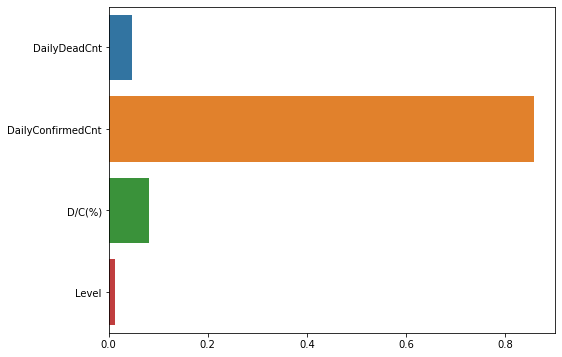

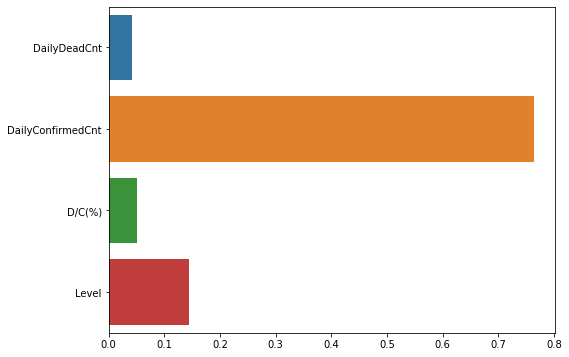

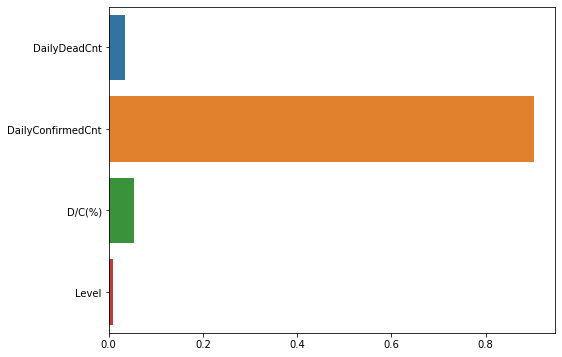

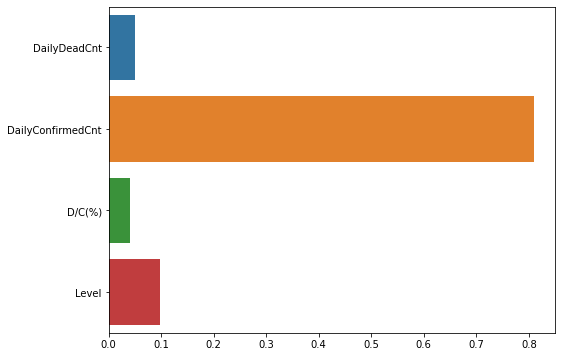

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(len(FI_list_df)):
    for j in range(len(FI_list_df[0])):
        importances_values = FI_list_df[i][j].feature_importances_
        importances = pd.Series(importances_values, index = X_train1.columns)

        plt.figure(figsize=(8,6), facecolor='w')
        # plt.subplot(i+1,j+1,4)
        sns.barplot(x=importances_values, y=importances.index)

    